### Preparing our data
1. First, we grab all our images with proper classes (every directory is a class)
2. Then we write the info into a DataFrame with columns (filepath, classname, classid)
3. Split our data frame to train frame and test frame

In [1]:
import pandas as pd
import os

def create_dataframe(directory: str) -> pd.DataFrame:
  '''
  Creates a data frame from a directory.
  Every subfolder represents a class.
  Every subfolder contains images of that class.
  '''

  # Get all subfolders
  subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]

  # create an empty data frame
  frame = pd.DataFrame(columns=['filepath', 'classname', 'classid'])

  # iterate over all subfolders
  for i, subfolder in enumerate(subfolders):
    # get all images in the subfolder
    images = [f.path for f in os.scandir(subfolder) if f.is_file()]

    class_name = os.path.basename(subfolder)

    # create a data frame for the subfolder
    df = pd.DataFrame(columns=['filepath', 'classname', 'classid'])
    df['filepath'] = images
    df['classname'] = class_name
    df['classid'] = i

    print(f'{class_name} is class {i}')

    # append the subfolder data frame to the main data frame
    frame = pd.concat([frame, df], ignore_index=True)

  return frame

flowers_frame = create_dataframe('flower_images')
flowers_frame.head()

Lotus is class 0
Tulip is class 1
Orchid is class 2
Lilly is class 3
Sunflower is class 4


,filepath,classname,classid
0,flower_images/Lotus/16905dde87.jpg,Lotus,0
1,flower_images/Lotus/839f7d1a14.jpg,Lotus,0
2,flower_images/Lotus/6acf5327ad.jpg,Lotus,0
3,flower_images/Lotus/327793cdf0.jpg,Lotus,0
4,flower_images/Lotus/c8e4698aa0.jpg,Lotus,0


In [2]:
from typing import TypeVar, Generic, Callable
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image

T = TypeVar('T')
ImageTransformer = Callable[[Image.Image], T]

class FlowersDataset(Dataset, Generic[T]):
  def __init__(self, frame: pd.DataFrame, transform: ImageTransformer | None = None) -> None:
    self.frame = frame
    self.transform = transform
  
  def __len__(self) -> int:
    return len(self.frame)
  
  def __getitem__(self, index: int) -> tuple[Image.Image | T, int]:
    row = self.frame.iloc[index]
    filepath, classid = row['filepath'], row['classid']
    image = Image.open(filepath)
    if self.transform:
      image = self.transform(image)
    return image, classid


In [3]:
import torch
import numpy as np

def image_to_tensor(image: Image) -> torch.Tensor:
  '''
  Converts an image to a tensor.
  '''
  image = image.convert('RGB')
  image = image.resize((224, 224))
  array = np.array(image)
  array = array.transpose((2, 0, 1))
  return torch.from_numpy(array).to(torch.float32) / 255.0

In [4]:
from torch.utils.data import random_split

train_size = int(len(flowers_frame) * 0.8)
test_size = len(flowers_frame) - train_size

train_frame, test_frame = random_split(flowers_frame, [train_size, test_size])
train_frame, test_frame = train_frame.dataset, test_frame.dataset

In [5]:
train_dataset = FlowersDataset(train_frame, transform=image_to_tensor)
test_dataset = FlowersDataset(test_frame, transform=image_to_tensor)

In [6]:
image, _ = train_dataset[0]
image.shape

torch.Size([3, 224, 224])

### Building the Neural Network
Here I use PyTorch for our neural network. We are trying to build a CNN <br>
First of all, we define our building blocks, which are convolutional units and dense units <br>
Then, we are building our neural network

In [7]:
import torch
from torch import nn


class ConvUnit(nn.Module):
  '''
  Convolutional Unit consisting of
  - Convolutional Layer
  - ReLU Activation
  - Batch Normalization
  - Max Pooling
  '''
  def __init__(self, in_channels: int, out_channels: int, conv_kernel: int = 3, pool_kernel: int = 2) -> None:
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=conv_kernel, padding=1)
    self.relu = nn.ReLU()
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_kernel)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    x = self.pool(x)
    return x
  

class DenseUnit(nn.Module):
  '''
  Dense Unit consisting of
  - Linear Layer
  - ReLU Activation
  - Batch Normalization
  - Dropout
  '''
  def __init__(self, in_features: int, out_features: int, droupout: float = 0.0, normalization: bool = True) -> None:
    super().__init__()
    self.linear = nn.Linear(in_features, out_features)
    self.relu = nn.ReLU()
    self.normalization = normalization
    if normalization:
      self.batch_norm = nn.BatchNorm1d(out_features)
    self.dropout = nn.Dropout(droupout)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.linear(x)
    x = self.relu(x)
    if self.normalization:
      x = self.batch_norm(x)
    x = self.dropout(x)
    return x


In [8]:
from torch import nn

class FlowerCNN(nn.Module):
  '''
  Convolutional Neural Network for classifying 5 types of flowers:
  - Lilly
  - Lotus
  - Orchid
  - Sunflower
  - Tulip

  Takes RGB images 224x224 pixels as input turned into tensors
  '''
  def __init__(self) -> None:
    super().__init__()
    self.extractor = nn.Sequential(
      ConvUnit(3, 32),
      ConvUnit(32, 64),
      ConvUnit(64, 128),
      ConvUnit(128, 256),
    )
    self.flatten = nn.Flatten()
    self.classifier = nn.Sequential(
      DenseUnit(50176, 1024, droupout=0.2),
      DenseUnit(1024, 256, droupout=0.2),
      DenseUnit(256, 64, droupout=0.2),
      DenseUnit(64, 5),
    )
    self.output_function = nn.Softmax(dim=1)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.extractor(x)
    x = self.flatten(x)
    x = self.classifier(x)
    x = self.output_function(x)
    return x


### Training Neural Network

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader

class Trainer:
  '''
  Trainer for a PyTorch model.
  Performs training and validation of a model.
  Trainer contains train and validation history.
  '''
  def __init__(self, model: nn.Module, learning_rate: float = 0.001) -> None:
    self.device = torch.device(self.device_name)
    self.model = model.to(self.device)
    self.loss_function = nn.CrossEntropyLoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    self.train_history = []
    self.validation_history = []

  @property
  def device_name(self) -> str:
    if torch.cuda.is_available():
      return 'cuda'
    if torch.backends.mps.is_available():
      return 'mps'
    return 'cpu'
  
  def train(self, train_loader: DataLoader, epochs: int = 10) -> None:
    self.model.train()
    for epoch in range(epochs):
      epoch_loss, epoch_accuracy = 0.0, 0.0
      for inputs, labels in train_loader:
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.loss_function(outputs, labels)
        loss.backward()
        self.optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        epoch_accuracy += torch.sum(predictions == labels.data)
      epoch_loss /= len(train_loader.dataset)
      epoch_accuracy /= len(train_loader.dataset)
      self.train_history.append((epoch_loss, epoch_accuracy.item()))
      print(f'Epoch {epoch+1}: loss={epoch_loss}, accuracy={epoch_accuracy}')
  
  def validate(self, validation_loader: DataLoader) -> tuple[float, float]:
    self.model.eval()
    epoch_loss, epoch_accuracy = 0.0, 0.0
    with torch.no_grad():
      for inputs, labels in validation_loader:
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        outputs = self.model(inputs)
        loss = self.loss_function(outputs, labels)
        epoch_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        epoch_accuracy += torch.sum(predictions == labels.data)
    epoch_loss /= len(validation_loader.dataset)
    epoch_accuracy /= len(validation_loader.dataset)
    self.validation_history.append((epoch_loss, epoch_accuracy.item()))
    print(f'Validation: loss={epoch_loss}, accuracy={epoch_accuracy}')
    return epoch_loss, epoch_accuracy
  
  def save_model(self, parent_dir: str) -> None:
    if not self.validation_history:
      name = 'model.pth'
    else:
      _, accuracy = self.validation_history[-1]
      name = f'model_{accuracy:.4f}.pth'
    path = os.path.join(parent_dir, name)
    state = self.model.state_dict()
    torch.save(state, path)


In [11]:
import matplotlib.pyplot as plt

def plot_history(history: list[tuple[float, float]], label: str) -> None:
  loss = [item[0] for item in history]
  accuracy = [item[1] for item in history]
  plt.plot(loss, label=f'{label} Loss')
  plt.plot(accuracy, label=f'{label} Accuracy')
  plt.legend()
  plt.show()

In [12]:
model = FlowerCNN()

In [13]:
trainer = Trainer(model)

In [14]:
trainer.train(train_loader, epochs=20)

Epoch 1: loss=1.427453416824341, accuracy=0.5202000141143799
Epoch 2: loss=1.3411365798950194, accuracy=0.6220000386238098
Epoch 3: loss=1.2772780269622803, accuracy=0.6972000598907471
Epoch 4: loss=1.2173587930679322, accuracy=0.7624000310897827
Epoch 5: loss=1.1687348155975341, accuracy=0.8114000558853149
Epoch 6: loss=1.1213625015258788, accuracy=0.8606000542640686
Epoch 7: loss=1.1230748632431031, accuracy=0.8432000279426575
Epoch 8: loss=1.077611488723755, accuracy=0.889400064945221
Epoch 9: loss=1.1440710372924805, accuracy=0.7998000383377075
Epoch 10: loss=1.053380499649048, accuracy=0.9032000303268433
Epoch 11: loss=1.0484234910964967, accuracy=0.9032000303268433
Epoch 12: loss=1.0170160257339478, accuracy=0.9314000606536865
Epoch 13: loss=0.9993316440582275, accuracy=0.9478000402450562
Epoch 14: loss=0.995054774093628, accuracy=0.9440000653266907
Epoch 15: loss=1.1361684764862061, accuracy=0.7850000262260437
Epoch 16: loss=1.0659772598266601, accuracy=0.8660000562667847
Epoch 

In [15]:
trainer.validate(test_loader)

Validation: loss=0.943987423324585, accuracy=0.9794000387191772


/Users/tikhon/Documents/flowers/.venv/lib/python3.11/site-packages/torch/_tensor_str.py:115: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  nonzero_finite_vals = torch.masked_select(


(0.943987423324585, tensor(0.9794, device='mps:0'))

In [16]:
trainer.validation_history

[(0.943987423324585, 0.9794000387191772)]

In [17]:
trainer.save_model('models')

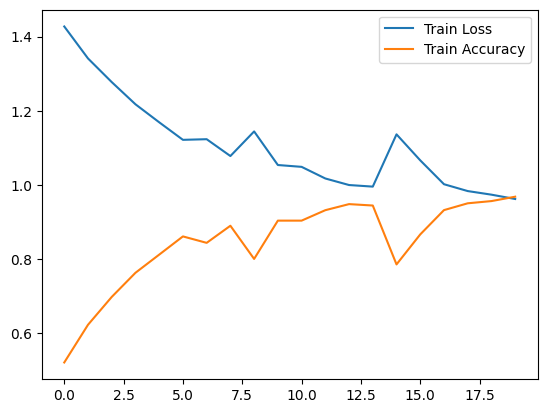

In [18]:
plot_history(trainer.train_history, 'Train')